# 한국어 데이터로 챗봇 만들기

transformer를 이용하여 챗봇을 만들어보자.

## 0. 모듈 import

In [1]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from konlpy.tag import Okt

## 1. 데이터 수집하기

학습할 데이터는 다음 출저에 받은 데이터를 사용한다.

https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

인공데이터로 일부 이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연"에서  
자주 나오는 이야기들을 참고하여 제작하였다고 한다.

In [2]:
data_path = os.getenv("HOME")+'/aiffel/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(data_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


각 질문(Q)에 대한 답변(A)과 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링으로  
구성되어있고, 따로 결측치는 없다.  
현재 만들 챗봇에는 딱히 라벨은 필요없으므로 제거해주자.

In [4]:
data = data.drop('label', axis=1)
data

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


##  2. 데이터 전처리하기

' '으로 단어들을 구분하자.  
대표적으로 [! ? , .] 등의 특수문자와 'ㅠㅠ' 'ㅋㅋ' 등의  
자음/모음으로만 의성어도 구분한다.  
그 외 쓰지 않는 특수문자등은 제거한다.

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 'ㅋㅋ', 'ㅠㅠ' 등의 자음/모음으로만 구성된 의성어도 나눈다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"([ㄱ-ㅎㅏ-ㅣ]+)", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 한글,영문자,숫자,?,.,!,,를 제외한 모든 문자를 공백 " "으로 대체한다.
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [6]:
preprocessed_data = data.applymap(lambda x : preprocess_sentence(x))
preprocessed_data.head()

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .


3박4일 처럼 숫자도 구분할까 했지만 일단 이대로 학습 시켜보자.

In [7]:
questions, answers = preprocessed_data.Q.values, preprocessed_data.A.values

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print('전처리 전의 8번째 질문 샘플: {}'.format(data.Q[7]))
print('전처리 전의 8번째 답변 샘플: {}'.format(data.A[7]))

전처리 전의 8번째 질문 샘플: SNS 맞팔 왜 안하지ㅠㅠ
전처리 전의 8번째 답변 샘플: 잘 모르고 있을 수도 있어요.


In [9]:
print('전처리 후의 8번째 질문 샘플: {}'.format(questions[7]))
print('전처리 후의 8번째 답변 샘플: {}'.format(answers[7]))

전처리 후의 8번째 질문 샘플: sns 맞팔 왜 안하지 ㅠㅠ
전처리 후의 8번째 답변 샘플: 잘 모르고 있을 수도 있어요 .


전처리 전 후를 비교해보면 의성어나 마침표 등이 잘 나누어진것을 확인 할 수 있다.

각 문장의 나누어진 단어 개수를 세워보자.

In [10]:
preprocessed_data['Q_length'] = preprocessed_data['Q'].str.count(' ')+1
preprocessed_data['A_length'] = preprocessed_data['A'].str.count(' ')+1
preprocessed_data.head()

,Q,A,Q_length,A_length
0,12시 땡 !,하루가 또 가네요 .,3,4
1,1지망 학교 떨어졌어,위로해 드립니다 .,3,3
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,3,4
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,4,4
4,ppl 심하네,눈살이 찌푸려지죠 .,2,3


In [11]:
length = pd.concat([preprocessed_data['Q_length'], preprocessed_data['A_length']])
length

0        3
1        3
2        3
3        4
4        2
        ..
11818    6
11819    4
11820    2
11821    9
11822    6
Length: 23646, dtype: int64

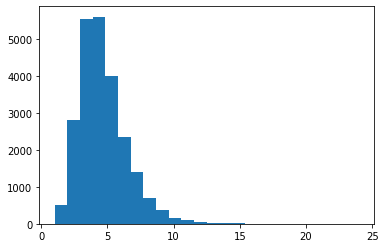

In [12]:
plt.hist(length, bins = 24)
plt.show()

최대 단어 개수는 24개까지 분포되어 있지만, 이후 토큰화 시키면서 개수가 늘어날 것이다.

## 3. Dataset 만들기

각 질문(Q)과 답변(A)을 입력과 출력으로 데이터셋을 만들 것이다.  
전처리한 단어를 토큰화 시키고 패딩 처리후 데이터셋으로 만든다.

토큰화 과정은 2가지 방법을 이용할 것이다.   
tensorflow_datasets의 내부 단어 토크나이저인 SubwordTextEncoder를 사용해서 토큰화시켜보자.  
다른 방법으로 konlpy 패키지의 Okt를 이용해서 형태소로 토큰화시켜보자.

### SubwordTextEncoder

target_vocab_size을 2^13=8192로 주었다.  
16384의 경우는 토큰화된 단어에서 쓸데 없는 중복이 많은 거 같았다.

In [13]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + ' ' + answers, target_vocab_size=2**13)

In [14]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]


In [15]:
VOCAB_SIZE = tokenizer.vocab_size + 2
f'토큰화된 단어의 개수 : {VOCAB_SIZE}'

'토큰화된 단어의 개수 : 8363'

토큰화된 단어는 14635개 이다.  

In [16]:
words = tokenizer.decode([i//2 if i%2 == 0 else 1  for i in range(1, (VOCAB_SIZE-2)*2)])
print(words[:800])
print(words[-800:])

 . . . .  . ?  .거예요 .수  .게  .너무  .더  .거  .좋아하는  .는  .이  .을  .잘  .고  .도  .것  .많이  .요 .안  .지  .나  .좋은  .다  .같아요 .사람  .가  .좀  .한  .있어요 .있을  .에  .은  .해보세요 .할  .면  .건  .싶어  .사람이  .를  .마세요 .하고  .하는  .같아  .네  .보세요 .죠 .서  .내가  .내  .의  .이제  .마음이  . ! .만  .썸  .다른  .그  .왜  .어떻게  .있는  .세요 .해  .다시  .시간이  .수도  .지 .이별  .것도  .오늘  .또  .좋을  .정말  .네요 .이 .같이  .해 .걸  .어  .는데  .될  .해요 .일  .자꾸  .나 .하세요 .없어요 .야  .길  .기  .로  .제가  .없어  .바랄게요 .하면  .싶다  .봐요 .때  .돼요 .으로  .가 .하지  .진짜  .저도  .먼저  .어 .에서  .그런  .헤어진지  .다 .나를  .주세요 .마음을  .데  .없는  .해도  .여자친구가  .혼자  .좋아요 .계속  .남자친구가  .못  .드세요 .줄  .않아요 .먹고  .네 .좋죠 .일이  .마음  .기 .힘든  .바랍니다 .보고  .날  .그럴  .연애  .연락  .아 .만큼  .있어  .생각해요 .말해보세요 .나봐요 .시간  .사랑이  .좋겠어요 .으면  .사람은  .뭐  .친구가  .주 .있으면  .무슨  .과  .있을까 .아직  .많은  .고 .니  .까 .그냥  .참  .인데  .에요 .안 . ,  .인  .이렇게  .보 .몰라요 .는게  .예요 .어떤
1년만 .12 .10년  .10개월 ..  . , ,  .  . . . . . . . . .	 .
 . . . . . . . . . . . . . . . . . . .  .! ." .# .$ .% .& .' .( .) .* .+ ., .- .. ./ .0 .1 .2 .3 .4 .5 .6 .7 .8 .9 .: 

### konlpy Okt
konlpy패키지의 Okt를 이용해서 형태소로 토큰화 시켜보자.

In [73]:
class OktTokenizer(Okt):
    def __init__(self, sentences):
        super().__init__()
        
        words = set()
        for sentence in sentences:
            words.update(self.morphs(sentence))
        
        self.vocab_size = len(words)
        self.word_to_index = {word:index for index, word in enumerate(words)}
        self.index_to_word = {index:word for word, index in self.word_to_index.items()}
        
    
    def encode(self, sentence):
        morphs = self.morphs(sentence)
        return [self.word_to_index[word] for word in morphs]
    
    
    def decode(self, sentence):
        return ' '.join(self.index_to_word[index] if index in self.index_to_word else '<UNK>' for index in sentence)

In [18]:
tokenizer_okt = OktTokenizer(preprocessed_data.Q + ' ' + preprocessed_data.A)

In [19]:
START_TOKEN_OKT, END_TOKEN_OKT = [tokenizer_okt.vocab_size], [tokenizer_okt.vocab_size + 1]

print('START_TOKEN의 번호 :', START_TOKEN_OKT)
print('END_TOKEN의 번호 :', END_TOKEN_OKT)

START_TOKEN의 번호 : [12651]
END_TOKEN의 번호 : [12652]


In [20]:
VOCAB_SIZE_OKT = tokenizer_okt.vocab_size + 2
f'토큰화된 단어의 개수 : {VOCAB_SIZE_OKT}'

'토큰화된 단어의 개수 : 12653'

In [21]:
np.array(list(tokenizer_okt.word_to_index.keys()))[:100]

array(['봐야겠다', '짐작', '만났어도', '보여주고싶은데', '경조사', '닳아', '작', '중요합니다', '버텨요',
       '진실되게', '들까', '쓰이고', '날이에', '추석', '나이스', '가릴까', '아쉽네요', '초미세먼지',
       '싶은신', '들텐데요', '중요해서', '빵꾸', '미안하지만', '분이네요', '싸게', '느껴지겠어요', '맡겨',
       '빠르면', '있기', '걸레질', '양말', '시원할', '겨우', '북', '처리', '줬으면', '편식',
       '누워', '알리', '깨고싶어', '상념', '용납', '버린', '서서히', '궁금하지', '단발', '미세먼지',
       '그러려니', '대빵', '놔야지', '재테크', '그리워지나요', '600일', '만을', '스테이크', '경과',
       '해외여행', '물어볼까', '거둘', '당했다는', '이라니', '갈거예요', '위험해요', '간단한', '드디어',
       '어이', '칼', '서먹해졌어', '올라갈', '좋아하다', '받아야', '전달', '환심', '두려운데', '아니',
       '화나', '일일일', '해봐야지', '새벽', '애매모호해', '모자라다고', '내려올', '수십', '지울',
       '코인', '재밌겠어요', '리', '궁', '모은', '이어', '강해지고', '잡념', '짜오', '몰랐구나',
       '인한', '듣는', '걷는다', '있자고', '변했으면', '됐습니다'], dtype='<U9')

두 가지의 다른 방법으로 토큰화 시킨 결과를 비교해보면,  
가장 큰 차이는 SubwordTextEncoder를 사용한 경우는 '시간이', '시간을' 처럼  
형태소가 아닌 단어 자체로 토큰화 시켰고, konlpy 패키지의 경우는  
'시간', '을' '이' 처럼 형태소로 토큰화 시킨 것을 알 수 있다.

In [22]:
print(questions[21])
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

가스비 장난 아님
정수 인코딩 후의 21번째 질문 샘플: [5867, 601, 2487, 4210]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7677, 8, 6382, 97, 1]


In [23]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer_okt.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer_okt.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [9130, 12087, 8311, 804]
정수 인코딩 후의 21번째 답변 샘플: [4248, 2501, 12328, 3295, 8030, 6643, 11251]


같은 '가스비 장난 아님' 아니라는 문장을  다른 개수로 토큰화 시킨 것을 볼 수있다.

다음은 입력, 출력들을 토큰화시키고, 패딩처리까지 하자.  
현재 나누어진 최대 단어 길이는 24개이지만 토큰화를 거치면서 좀 더 늘어날 것이다.  
다만 애초에 길이가 그렇게 크지 않으므로 따로 길이를 정하지 않고,  
토큰화 시킨 후 구한 최대 토큰 길이로 패딩을 할 것이다.

In [24]:
def tokenize_and_filter(tokenizer, inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    # 최대 토큰 길이
    max_length = 0
    start_token = [tokenizer.vocab_size]
    end_token = [tokenizer.vocab_size + 1]
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = start_token + tokenizer.encode(sentence1) + end_token
        sentence2 = start_token + tokenizer.encode(sentence2) + end_token
        max_length = max(max_length, max(len(sentence1), len(sentence2)))

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_length, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding='post')

    return tokenized_inputs, tokenized_outputs, max_length

In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

def create_dataset(inputs, outputs):
    # 디코더는 이전의 target을 다음의 input으로 사용합니다.
    # 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': inputs,
            'dec_inputs': outputs[:, :-1]
        },
        {
            'outputs': outputs[:, 1:]
        },
    ))

    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [26]:
tokenized_questions, tokenized_answers, MAX_LENGTH = tokenize_and_filter(tokenizer, questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('최대 토큰 길이 : ', MAX_LENGTH)
print('필터링 후의 질문 샘플 개수: {}'.format(len(tokenized_questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(tokenized_answers)))

단어장의 크기 : 8363
최대 토큰 길이 :  31
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


토큰화 후 최대 길이가 31로 늘었지만, 충분히 학습 가능한 길이이다.

In [27]:
tokenized_questions

array([[8361, 8100, 2957, ...,    0,    0,    0],
       [8361, 8154,   67, ...,    0,    0,    0],
       [8361, 8156, 1417, ...,    0,    0,    0],
       ...,
       [8361, 8342, 8262, ...,    0,    0,    0],
       [8361,  132,  137, ...,    0,    0,    0],
       [8361, 1724,  984, ...,    0,    0,    0]], dtype=int32)

In [28]:
dataset = create_dataset(tokenized_questions, tokenized_answers)

마찬가지로 otk로 토큰화시켜서 데이터셋을 만들어보자.

In [29]:
tokenized_questions_okt, tokenized_answers_okt, MAX_LENGTH_OKT = tokenize_and_filter(tokenizer_okt, questions, answers)

print('단어장의 크기 :', tokenizer_okt.vocab_size)
print('최대 토큰 길이 : ', MAX_LENGTH_OKT)
print('필터링 후의 질문 샘플 개수: {}'.format(len(tokenized_questions_okt)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(tokenized_answers_okt)))

단어장의 크기 : 12651
최대 토큰 길이 :  33
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


형태소로 나누다 보니 최대 길이 33으로 좀 더 길다.

In [30]:
dataset_okt = create_dataset(tokenized_questions_okt, tokenized_answers_okt)

## 4. 모델 구성하기

transfomer 모델을 구성해보자.

In [31]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [32]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [34]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [35]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [37]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [39]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [40]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [41]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [42]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [43]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [44]:
tf.keras.backend.clear_session()

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195136     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [45]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

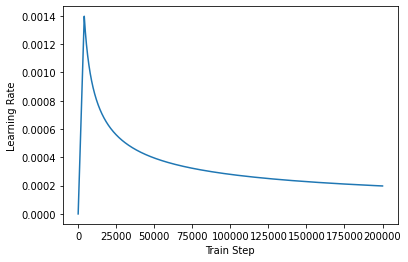

In [47]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [48]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

SubwordTextEncoder을 통해 만든 데이터셋을 우선 학습시켜보자.  

In [50]:
EPOCHS = 40
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 26s 93ms/step - loss: 1.9842 - accuracy: 0.0192
Epoch 2/40
185/185 [==============================] - 17s 91ms/step - loss: 1.6286 - accuracy: 0.0641
Epoch 3/40
185/185 [==============================] - 17s 91ms/step - loss: 1.3412 - accuracy: 0.0653
Epoch 4/40
185/185 [==============================] - 17s 91ms/step - loss: 1.2281 - accuracy: 0.0696
Epoch 5/40
185/185 [==============================] - 17s 92ms/step - loss: 1.1463 - accuracy: 0.0729
Epoch 6/40
185/185 [==============================] - 17s 92ms/step - loss: 1.0710 - accuracy: 0.0790
Epoch 7/40
185/185 [==============================] - 17s 92ms/step - loss: 0.9772 - accuracy: 0.0860
Epoch 8/40
185/185 [==============================] - 17s 92ms/step - loss: 0.8854 - accuracy: 0.0957
Epoch 9/40
185/185 [==============================] - 17s 91ms/step - loss: 0.7679 - accuracy: 0.1081
Epoch 10/40
185/185 [==============================] - 17s 92ms/step - loss: 0.667

In [51]:
def draw_history(history):
    fig = plt.figure(figsize=(15, 5))
    loss_ax = fig.add_subplot(1, 2, 1)
    acc_ax = fig.add_subplot(1, 2, 2)

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_xlabel('epoch')
    acc_ax.set_ylabel('accuray')

    plt.show()

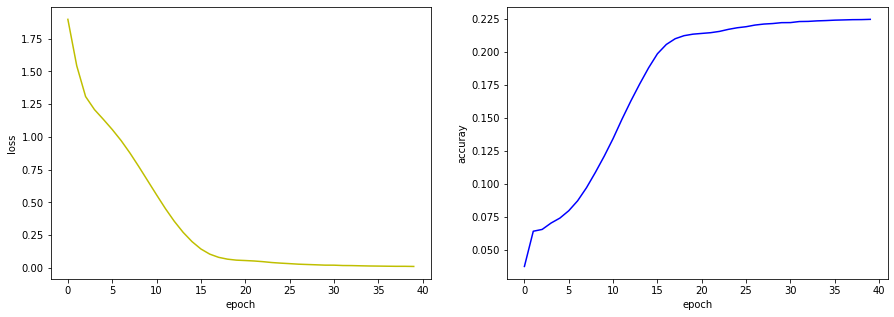

In [52]:
draw_history(history)

대략 epoch 20 부터 수렴하는 것을 확인 할 수 있다.

다음으로 konlpy 패키지의 Okt로 만든 데이터셋을 학습시켜보자.

In [53]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH_OKT - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [54]:
tf.keras.backend.clear_session()

model_okt = transformer(
    vocab_size=VOCAB_SIZE_OKT,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH_OKT - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model_okt.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [55]:
EPOCHS = 40
history_okt = model_okt.fit(dataset_okt, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 32s 121ms/step - loss: 2.1103 - accuracy: 0.0181
Epoch 2/40
185/185 [==============================] - 22s 118ms/step - loss: 1.6757 - accuracy: 0.0610
Epoch 3/40
185/185 [==============================] - 23s 124ms/step - loss: 1.2771 - accuracy: 0.0624
Epoch 4/40
185/185 [==============================] - 24s 129ms/step - loss: 1.1076 - accuracy: 0.0721
Epoch 5/40
185/185 [==============================] - 23s 123ms/step - loss: 1.0102 - accuracy: 0.0840
Epoch 6/40
185/185 [==============================] - 23s 126ms/step - loss: 0.9175 - accuracy: 0.0921
Epoch 7/40
185/185 [==============================] - 23s 126ms/step - loss: 0.8409 - accuracy: 0.0999
Epoch 8/40
185/185 [==============================] - 24s 129ms/step - loss: 0.7579 - accuracy: 0.1073
Epoch 9/40
185/185 [==============================] - 25s 138ms/step - loss: 0.6719 - accuracy: 0.1172
Epoch 10/40
185/185 [==============================] - 26s 142ms/step - l

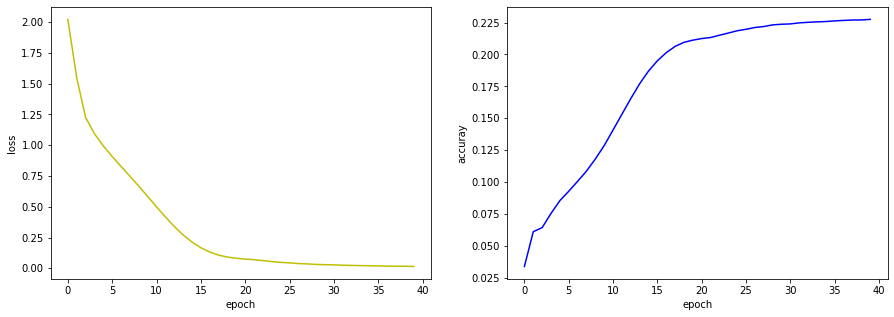

In [56]:
draw_history(history_okt)

## 5. 모델 평가하기

입력된 문장에 대해서 대답을 얻는 예측 함수를 만들어서 사용해보자.

In [57]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [58]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction.numpy() if i < tokenizer.vocab_size])

    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

### SubwordTextEncoder 모델

In [59]:
sentence_generation('누구세요?')

출력 : 저는 위로해드리는 로봇이에요 .


'저는 위로해드리는 로봇이에요 .'

In [60]:
sentence_generation('누구냐 넌?')

출력 : 저는 마음을 이어주는 위로봇입니다 .


'저는 마음을 이어주는 위로봇입니다 .'

In [61]:
sentence_generation('ㅋㅋ')

출력 : 좋은 연락이었길 바랍니다 .


'좋은 연락이었길 바랍니다 .'

In [62]:
sentence_generation('쉬고 싶다.')

출력 : 내려 놓으세요 .


'내려 놓으세요 .'

나름 결과가 잘 나온것 같다.  
같은 의미의 질문에도 묻는 뉘앙스에 따라 대답하는 방식이 바뀌는 것은 신기하기도 하다.  
다만 'ㅋㅋ'라는 문장에 뜬끔 없는 대답을 하는데,  
이는 학습 데이터 자체가 이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연" 이다보니  
대체적으로 위로해주는 말들을 학습되게 된것 같다.  

### konlpy Okt 모델

In [65]:
model = model_okt
tokenizer = tokenizer_okt
START_TOKEN, END_TOKEN = START_TOKEN_OKT, END_TOKEN_OKT
MAX_LENGTH = MAX_LENGTH_OKT

In [66]:
sentence_generation('누구세요?')

출력 : 저 는 위로 해드리는 로봇 이에요 .


'저 는 위로 해드리는 로봇 이에요 .'

In [70]:
sentence_generation('오늘 날씨가 참 좋네.')

출력 : 좋은 사람 이 찾아오려나 봐요 .


'좋은 사람 이 찾아오려나 봐요 .'

In [71]:
sentence_generation('아무 것도 하기 싫다.')

출력 : 저 도 요 !


'저 도 요 !'

위의 단순히 단어별로 토큰화해서 학습 시킨 경우와 같은 대답을 하지만,  
형태소로 분리하다 보니 대답도 형태소로 분리되어있다.  
여러가지 질문을 하다보면 학습된 디테일에서도 차이가 나는 것을 확인 할 수 있었다.

## 회고

이번 프로젝트를 하면 Transformer라는 것에 대해 정말 많은 공부가 된 것 같다.  
특히 문장을 seq2seq나 이전 언어모델들과 다르게  
RNN 이나 LSTM을 사용해서 재귀적으로 입력을 넣는게 아니라,  
Attention을 통해서 한번에 문장을 입력으로 사용하는 아이디어가 대단한 것 같다.

그 외에도 Q, K, V를 통한 어텐션 계산이나 sin, cos을 이용한 positioning 등  
여러 부분에서 참신했고, 많은 것을 배운 것 같다.